# MSCI 434 MIP Model (Team 7)

In [318]:
# %pip install pandas
# %pip install geopy
# %pip install numpy
# %pip install gurobipy

In [319]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import networkx as nx
from geopy.distance import geodesic
import numpy

small_path = "./main_data/small_data/"
main_path = "./main_data/"
result_path = "./results/"

**Load Data**

In [320]:
# Function -------------------------------------------------------------
def load_total_demand():

    yearly_sales = pd.read_csv(f'{main_path}vw_yearly_sales.csv')
    return yearly_sales


# Function -------------------------------------------------------------
def load_dcs(small = False):
  
    # NOTE: stateconst is a constant used to account for the different prices for the cost of living and rent in various states
    if small:
        dcs = pd.read_csv(f'{small_path}small_list_of_dcs.csv', encoding= 'unicode_escape', names=['ID', "Name","City","State","Address Line 1","Address Line 2", "Coordinates", "Area m3", "Facility Type", "StateConst"])
    else:
        dcs = pd.read_csv(f'{main_path}list_of_dcs.csv', encoding= 'unicode_escape', names=['ID', "Name","City","State","Address Line 1","Address Line 2", "Coordinates", "Area m3", "Facility Type", "StateConst"])

    dcs['Area sqft'] = round(dcs['Area m3'] * 10.7639)
    # dcs = dcs.drop(dcs[dcs['State'] == 'TN'].index)
    # # Assuming dcs is the DataFrame after dropping rows with 'TN' in the 'State' column
    # dcs = dcs.reset_index(drop=True)

    # # Now, renumber the IDs starting from 0
    # dcs['ID'] = range(len(dcs))
    return dcs


# Function -------------------------------------------------------------
def load_dealers(small = False):
  # https://www.vw.com/app/dccsearch/vw-us/en/Find%20a%20Volkswagen%20Dealer/+/38.353354499999995/-95.3817145/3/+/+/+/+

    if small:
        dealers = pd.read_csv(f'{small_path}small_list_of_dealers.csv',names=['ID', "Name","Address Line 1","Address Line 2", "Website","Phone Number", "Coordinates"])
    else:
        # FULL DATASET
        dealers= pd.read_csv(f'{main_path}list_of_dealers.csv',names=['ID', "Name","Address Line 1","Address Line 2", "Website","Phone Number", "Coordinates"])
    
    return dealers

# Function -------------------------------------------------------------
def load_plants():
    
    plants= pd.read_csv(f'{main_path}list_of_vw_plants_and_products.csv', encoding= 'unicode_escape',names=['ID', "City","Country", "Model","Coordinates","Current/Former plant"])
    plants_usa = plants.loc[plants["Country"]=="USA"]

    return plants_usa


# Function -------------------------------------------------------------
# Used google ratings as a indicator of demand/traffic
def load_dealer_demands():

    def single_sample():
        # 4 samples
        dealers= pd.read_csv(f'{small_path}small_list_of_demand_data.csv',names=['ID',"Name","Rating","Proportion","na"])
        del dealers[dealers.columns[-1]]
        return dealers

    def full_data():
        # FULL DATASET
        dealers= pd.read_csv(f'{main_path}list_of_demand_data.csv',names=['ID',"Name","Rating","Proportion","na", "na2", "na3"])
        del dealers[dealers.columns[-1]]
        del dealers[dealers.columns[-1]]
        del dealers[dealers.columns[-1]]
        return dealers

    # either call single_sample or full_data
    dealers = full_data() 

    return dealers


In [321]:
# Get all plants, DCs, and Dealers
plants = load_plants()
dcs = load_dcs()
dealers = load_dealers()

**View Data**

In [322]:
load_total_demand()

,year,ID4,TAOS,Cross Sport,Arteon,Tiguan,Atlas,Routan,Touareg,Tiguan.1,CC,EOS,Passat,Jetta,Golf,Beetle
0,2008,0,0,0,0,0,0,3387,6755,8664,2105,12837,30034,97461,35408,26477
1,2009,0,0,0,0,0,0,14651,4392,13903,23872,7204,11138,108427,15752,14085
2,2010,0,0,0,0,0,0,15961,4713,20946,27987,6690,12497,123213,28286,16573
3,2011,0,0,0,0,0,0,12473,7535,2599,29502,7533,22835,177360,34706,6468
4,2012,0,0,0,0,0,0,10484,10553,31731,21646,6214,117023,170424,40885,29174
5,2013,0,0,0,0,0,0,2109,8233,3000,15672,4178,109652,163793,30931,43134
6,2014,0,0,0,0,0,0,1103,6961,25121,9995,3411,96649,160873,33675,29182
7,2015,0,0,0,0,0,0,0,8223,35843,6276,2993,78207,131109,65308,22667
8,2016,0,0,0,0,0,0,0,4223,43638,3237,387,73002,121107,61687,15667
9,2017,0,0,0,0,21023,27119,0,3545,25960,1355,1,60722,115807,68978,15166


In [323]:
load_plants()

,ID,City,Country,Model,Coordinates,Current/Former plant
25,9,Chattanooga,USA,Atlas,"35.077103086458976, -85.13084428224508",current
26,9,Chattanooga,USA,Cross Sport,"35.077103086458976, -85.13084428224508",current
27,9,Chattanooga,USA,ID4,"35.077103086458976, -85.13084428224508",current
28,9,Chattanooga,USA,Passat,"35.077103086458976, -85.13084428224508",former


In [324]:
load_dcs()

,ID,Name,City,State,Address Line 1,Address Line 2,Coordinates,Area m3,Facility Type,StateConst,Area sqft
0,0,Volkswagen Parts Distribution Center,Ontario,CA,3095 E Cedar St,"Ontario, CA 91761","34.0376080290585, -117.58641507359258",30456,1,68814,327825.0
1,1,Volkswagen Parts Distribution Center,Rocklin,CA,1100 Tinker Rd,"Rocklin, CA 95765, United States","38.81328171265908, -121.30150120229099",18360,1,91290,197625.0
2,2,Volkswagen Parts Distribution Center,Jacksonville,FL,4150 Perimeter Industrial Pkwy N,"Jacksonville, FL 32219, United States","30.373771993405768, -81.75890718718041",362670,2,82698,3903744.0
3,3,Volkswagen Parts Distribution Center,Cranbury,NJ,47 Station Rd,"East Windsor, NJ 08512, United States","40.3071068545627, -74.50867073108051",103200,2,77204,1110834.0
4,4,Volkswagen Group of America Parts Distribution...,Ft. Worth,TX,230 Intermodal Pkwy,"Fort Worth, TX 76177, United States","32.96678488424622, -97.32814574044846",55954,1,62672,602283.0
5,5,Volkswagen Parts Distribution Center,Pleasant Prairie,WI,11589 88th Ave,"Pleasant Prairie, WI 53158, United States","42.5108270307348, -87.91110551996559",23217,1,66901,249905.0


In [325]:
load_dealers()

,ID,Name,Address Line 1,Address Line 2,Website,Phone Number,Coordinates
0,0,Alexandria Volkswagen,107 W Glebe Rd,"Alexandria, VA 22305",https://alexandriavw.com,(703) 684-8888,"38.83578067871878, -77.05799331320739"
1,1,Ancira Volkswagen,6125 Bandera Rd,"San Antonio, TX 78238",https://anciravolkswagen.com,(210) 681-2300,"29.488410637739907, -98.60618875952487"
2,2,Ancira Volkswagen of Laredo,2701 N.E. Bob Bullock Loop,"Laredo, TX 78045",https://vwlaredo.com,(956) 717-2200,"27.612614635541124, -99.47040125767218"
3,3,Andy Mohr Volkswagen of Avon,8791 E Us Highway 36,"Avon, IN 46123",https://www.andymohrvw.com,(317) 978-0296,"39.76232468061578, -86.36526215581948"
4,4,Antelope Valley Volkswagen,39050 Carriage Way,"Palmdale, CA 93551",https://vwantelopevalley.com,(661) 273-2500,"39.764347438993674, -86.37612026718733"
...,...,...,...,...,...,...,...
633,633,Wynn Volkswagen,2021 W Main St,"Norristown, PA 19403",https://jimwynnvw.com,(610) 539-1100,"40.133512710158975, -75.37891900773616"
634,634,"York Volkswagen, Inc.",3475 E Market St,"York, PA 17402",https://www.yorkvw.com,(717) 755-1015,"39.98167762462809, -76.65493938869697"
635,635,Young Volkswagen of Layton,1230 N Main St,"Layton, UT 84041",https://www.youngvolkswagen.com,(801) 544-5878,"41.07908703469315, -111.98269918866244"
636,636,Zimbrick Volkswagen,7505 Century Ave,"Middleton, WI 53562",https://www.z-vw.com,(608) 836-7777,"43.11080320619693, -89.51033578674627"


In [326]:
load_dealer_demands()

,ID,Name,Rating,Proportion
0,0,Alexandria Volkswagen,4.4,2984
1,1,Ancira Volkswagen,4.5,1913
2,2,Ancira Volkswagen of Laredo,4.1,271
3,3,Andy Mohr Volkswagen of Avon,4.5,1432
4,4,Antelope Valley Volkswagen,4.2,458
...,...,...,...,...
633,633,Wynn Volkswagen,4.6,432
634,634,"York Volkswagen, Inc.",4.3,380
635,635,Young Volkswagen of Layton,4.4,1153
636,636,Zimbrick Volkswagen,4.7,633


**Location Work**

In [327]:
# NOTE: Distances are in miles (mi).
# NOTE: All areas are in square-feet (sqft)

# Function -------------------------------------------------------------
def dc_to_dealer_distances(dcs, dealers): 
    
    # using geodesic distance, may want to add 15% or something onto distance
    distance_dc_to_dealer = numpy.zeros((len(dcs), len(dealers)))

    for dc_id, dc in dcs.iterrows():

      for dealer_id, dealer in dealers.iterrows():

        point1, point2 = dc["Coordinates"].split(","), dealer["Coordinates"].split(",")
        distance = geodesic(point1, point2).miles
        dc_id = dc["ID"]
        dealer_id = dealer["ID"]
        distance_dc_to_dealer[dc_id][dealer_id] = distance

    distance_dc_to_dealer_df = pd.DataFrame(distance_dc_to_dealer)
    
    return distance_dc_to_dealer_df


# Function -------------------------------------------------------------
def plant_to_dc_distances(plants, dcs):
  
  # get coordinates of the 1 usa plant
  plant_coordinates = plants['Coordinates'].iloc[0].split(",")
  distance_plants_to_dcs = [] # since we only have 1 usa plant we can just make everything from there (very convenient)
  
  for dcs_id, dc in dcs.iterrows():

    point1 = plant_coordinates
    point2 = dc["Coordinates"].split(",")
    distance = geodesic(point1, point2).miles
    dc_id = dc["ID"]
    distance_plants_to_dcs.append(distance)
  
  return distance_plants_to_dcs

# Get distances from plant-to-DC and DC-to-dealer
dcs_to_dealers = dc_to_dealer_distances(dcs, dealers)
plants_to_dcs = plant_to_dc_distances(plants, dcs)

**Calculate Demand**

In [328]:
# Function -------------------------------------------------------------
def get_dealer_demands(year):
  
  dealer_demands = load_dealer_demands()
  # demand for each specific car type
  total_demands = load_total_demand() 

  def get_demands(year):
    year_demands = total_demands.loc[total_demands['year'] == year]
    year_demands = year_demands[["Atlas","Cross Sport","ID4","Passat"]]
    return year_demands

  year_demands = get_demands(2021)
  year_demands = year_demands.values.tolist()[0]

  proportion_sum = dealer_demands["Proportion"].sum()

  dealer_demands [["Ratio of sales"]] = None
  dealer_demands["Ratio of sales"] = dealer_demands["Proportion"]/proportion_sum

  temp = []

  for x in list(dealer_demands["Ratio of sales"]):

    temp1=[]

    for y in list(year_demands):
      
      temp1.append(round(x*y))

    temp.append(temp1)

  sales = pd.DataFrame(temp, columns=["Atlas","Cross Sport","ID4","Passat"])
  
  return sales

In [329]:
# the left side are the dealer ids
sales = get_dealer_demands(2021)

**Calculating Costs**

In [330]:
# Function -------------------------------------------------------------
def calculate_dc_cost():
    
    # Function -------------------------------------------------------------
    def calculate_dc_cost_monthly(id, state, facility_type, areasqft):
        
        #2$ baseline
        # cost = 1.5*areasqft 

        # https://glcdistribution.com/customer-resources/tools/warehousing-insurance-calculator/ 1 million dollar standard
        insurance = 3850 

        # https://www.payscale.com/research/CA/Job=Warehouse_Material_Handler/Hourly_Rate
        employee_salaries = (areasqft/5000)*20*(40*4) 

        # pay 0.25 cents per sqft for utility
        utilities = 0.25*areasqft

        # $600 – $950 per month to lease a $50,000 forklift.
        # https://discord.com/channels/260272353118912522/1093655130076893284/1129635416409133076 1 forklift services 5000 sqft
        # We want to overwork it.
        forklift_cost =  areasqft/10000  * 600

        # https://discord.com/channels/260272353118912522/1093655130076893284/1129639090942398504
        price_it_costs_to_build_warehouse_sqft = 100*areasqft
        property_tax = 6/1000*price_it_costs_to_build_warehouse_sqft

        # 1000 fixed cost monitoring + 20$/h * 40h/week * 28 people
        security = 1000 + (5 * 8 * 28*20) 

        # Assuming Facility 1 has much lower space and so should be priced lower.
        if facility_type == 1:
            ft = 0.10
        else:
            ft = 0.5

        # 508 is the price of 100 big macs and state is the price of 100 big macs in that state
        price = (insurance + employee_salaries + utilities + forklift_cost + security + property_tax)*((state*0.1)/508)*ft
        
        return price

    prices = []

    for i in range(len(dcs.index)):
        moneys = calculate_dc_cost_monthly(float(dcs.loc[i,["ID"]]), float(dcs.loc[i,["StateConst"]]), float(dcs.loc[i,["Facility Type"]]),float(dcs.loc[i,["Area sqft"]]))
        prices.append(round(moneys*12, 2))
    
    return prices

# Function -------------------------------------------------------------
def calculate_dc_shipment_capacity(capacity = False):
  
  # This is: C_i
  # The largest car to consider is the Cross Sport
  # It has dimensions: 4,966 mm L x 1,990 mm W x 1,723 mm H
  # we can round this up to: 17 ft length, 7 foot wide, 6 foot tall
  # add about 2 ft to everything as a buffer
  # new measurement is about 18 ft length, 8ft wide, 8 foot tall
  # so, we can predict that 2 car takes up 144/2, each car takes 72 sq foot

  # from https://discord.com/channels/260272353118912522/1093655130076893284/1131271495004459018,
  # we see that 60-80% of DCs are for storage. Let's assume 60%
  vehicle_capacity = dcs["Area sqft"]*0.6 / 72

  # from https://discord.com/channels/260272353118912522/1093655130076893284/1131266537869820075
  # we see that most vehicles stay in the dc a couple of weeks (take 2 weeks)
  # we can frame this as: All vehicles in the DCS arrive at time 0, and after 2 weeks all are released
  annual_throughput = round(vehicle_capacity*6, 0)

  if capacity:
    return list(vehicle_capacity)
  else:
    return (list(annual_throughput))
  

In [331]:
calculate_dc_shipment_capacity()

[16391.0, 9881.0, 195187.0, 55542.0, 30114.0, 12495.0]

In [332]:
calculate_dc_cost()

[8702729.13, 7193265.63, 593672649.84, 159487904.66, 14223908.57, 6552127.22]

## Important Verbiage

Has most of the answers:

def generate_facility_cost

---
**Generally 2-3$ per square foot**
https://www.warehousingandfulfillment.com/resources/fulfillment-cost-calculator/

1. Rent or Mortgage:
[A 50,000 square foot steel warehouse, in the words of one construction expert, will cost between 52,800 and 312,500 per month in addition to monthly rent, utilities, insurance, and other associated costs. A 100,000 increase in the monthly budget will be made up of the cost of a turnkey warehouse, which will also be included in the estimate.](https://www.hechtgroup.com/the-average-size-of-a-small-warehouse-is-1-000-5-000-square-feet/)


2. Insurance:
- a standard warehouse general liability is 1-2 million of coverage, which is about 100/month
3. Salaries:
```
There is no definitive answer to how many employees per square foot warehouse as it depends on a variety of factors such as the type of products being stored, the level of automation in the warehouse, and the workflows. However, a good rule of thumb is to have one employee for every 1,000-1,500 square feet of warehouse space. This allows for efficient operations and ensures that there is enough staff to handle the volume of work.Every employee in a warehouse is allocated about 200-250 square feet of space. Distribution centers had a median square footage of 240,410 in 2016, 176,600 in 2017, and 305,000 in 2018. If a warehouse is properly designed, it will be more efficient and require less space per employee than if it is poorly designed. The number of warehouse employees varies greatly. Warehouses in general are less than 10,000 square feet in size. Eight-hour shifts pay between $14.80 and $19.90 per hour on average. Approximately 35% of the total warehouse space is estimated to be occupied by this type of warehouse.
```
`https://www.hechtgroup.com/how-many-employees-should-a-warehouse-have-per-square-foot/`

4. Utilities:
- [average utlity cost per square foot commercial property is about 1 dollar/sqft for electricity](https://www.iotacommunications.com/blog/average-utility-cost-per-square-foot-commercial-property/)
5. Equipment:
875$ lease a forklift

6. Licensing and Permits:

7. Maintenance and Repairs:

8. Property Taxes:

9. Security:

10. Technology:

## Back to Code

**Determining the Cost of Transportation**

In [333]:
## THE FUNCTION OF SHIPPING TRUCKS CAN BE APPROXIMATED BY A PIECEWISE FUNCTION
# https://www.desmos.com/calculator/ipxbog2uyr
# constructed from the data here: https://www.marketwatch.com/guides/car-shipping/truck-shipping/#:~:text=According%20to%20quotes%20we%20received,when%20using%20an%20enclosed%20carrier.

# Function -------------------------------------------------------------
def fixed_cost_shipment(): 
  # This is: T_1
  # cost to drive 0 miles
  return 186 


# Function -------------------------------------------------------------
def calculate_variable_cost_shipment(mileage): 
  # This is: T_2
  # if mileage < 1135:
  #   return mileage * (551/535)
  # return mileage * (0.43)
  return (0.43)

  # TODO: WE ARE ASSUMING FOR SIMPLICYT SAKE 0.43$/MILE AND ARE NOT CONSIDERING THE OTHER FUNCTION FOR MODELLING RIGHT NOW

In [334]:
## The modelling?
import gurobipy as gp
from gurobipy import GRB

# Create environment with WLS license
e = gp.Env(empty=True)
e.setParam('WLSACCESSID', '47fa1c45-5377-4f93-87d4-3da7da2b6955')
e.setParam('WLSSECRET', '7dfbddcb-7333-4ec7-927d-b459cffd9565')
e.setParam('LICENSEID', 868415)
e.start()

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 868415
Academic license - for non-commercial use only - registered to anita.yang@uwaterloo.ca


<gurobipy.Env, Parameter changes: WLSAccessID=(user-defined), WLSSecret=(user-defined), LicenseID=868415>

In [335]:
# Get all distances, demands, and costs
dcs_to_dealers = dc_to_dealer_distances(dcs, dealers)
plants_to_dcs = plant_to_dc_distances(plants, dcs)
dealer_demands = get_dealer_demands(2021) ## car demand for each dealership
dc_annual_cost = calculate_dc_cost()
# holding_costs = calculate_hold_costs()

In [336]:
# define sets
# set S
plants_set = [0]
# set I
dcs_set = list(dcs["ID"])
# set J
dealers_set = list(dealers["ID"])
# we define 0 to 3, corresponding to Atlas, CrossSport, ID4 and Passat vehicles (set V)
vehicle_set = [0,1,2,3]
# set P
facility_type_set = [0, 1]

In [337]:
# Parameter prep - we change the dataframes to arrays of sorts, which we can use indexes and such in the formulation
d_jv = dealer_demands.values
m_ij = dcs_to_dealers.values
c_si = plants_to_dcs
# load factor is 1
L_j = 1 
T_1 = fixed_cost_shipment()
T_2 = calculate_variable_cost_shipment("dummy_value") # see code comments on why we do this as a temp hack for a preliminary model
f_ip = dc_annual_cost
C_i = calculate_dc_shipment_capacity()

In [338]:
# Create Model
m = gp.Model(env=e)

# CREATE THE DECISION VARIABLES HERE
x1_siv = m.addVars(plants_set, dcs_set, vehicle_set, vtype=GRB.INTEGER)
x2_ijv = m.addVars(dcs_set, dealers_set, vehicle_set, vtype=GRB.INTEGER)
y_ip = m.addVars(dcs_set, facility_type_set, vtype=GRB.BINARY)

In [339]:
obj1 = sum((x2_ijv[i, j, v]/L_j)*(T_1 + T_2*m_ij[i, j]) for v in vehicle_set for j in dealers_set for i in dcs_set)

obj2 = sum(sum(x2_ijv[i, j, v] + x1_siv[s, i, v] for v in vehicle_set for j in dealers_set for s in plants_set) * c_si[i] for i in dcs_set)

obj3 = sum(x1_siv[s, i, v] for v in vehicle_set for s in plants_set for i in dcs_set)

obj4 = sum(f_ip[i]*y_ip[i, p] for p in facility_type_set for i in dcs_set)

m.setObjective(obj1 + obj2 + obj3 + obj4, gp.GRB.MINIMIZE)

In [340]:
# Constraint 1: Demand at each market area for each vehicle type must be met
m.addConstrs(sum(x2_ijv[i, j, v] for i in dcs_set) == d_jv[j, v] for v in vehicle_set for j in dealers_set)

# Constraint 2: Vehicle flows between plants and DCs must be conserved
m.addConstrs(sum(x1_siv[s, i, v] for s in plants_set) == sum(x2_ijv[i, j, v] for j in dealers_set) for i in dcs_set for v in vehicle_set)

# Constraint 3 min: Total vehicle flow to each DC must satisfy the minimum capacity requirement
m.addConstrs(
    (C_i[i] * y_ip[i, 1] <= sum(x2_ijv[i, j, v] for v in vehicle_set for j in dealers_set) for i in dcs_set),
    name="constraint_3_min"
)

# Constraint 3 max: Total vehicle flow to each DC must satisfy the maximum capacity requirement
m.addConstrs(
    (sum(x2_ijv[i, j, v] for v in vehicle_set for j in dealers_set) <= C_i[i] * y_ip[i, 0] + sum(d_jv[j, v] for v in vehicle_set for j in dealers_set) * y_ip[i, 1] for i in dcs_set),
    name="constraint_3_max"
)

# # Constraint 4: Shipment quantities must be nonnegative
m.addConstrs(x1_siv[s, i, v] >= 0 for s in plants_set for v in vehicle_set for i in dcs_set)
m.addConstrs(x2_ijv[i, j, v] >= 0 for i in dcs_set for v in vehicle_set for j in dealers_set)

# Constraint 6: The distribution centers must be selected so that all market areas can be reached within r days. 
#               Suppose a truck travels on average 300 miles a day. (Redundant constraint)
# r=60
# m.addConstrs((sum(x2_ijv[i, j, v] for v in vehicle_set) == 0 for i in dcs_set for j in dealers_set if m_ij[i][j] / 300 > r))

{(0, 0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 0, 18): <gurobi.Constr *Awaiting 

In [341]:
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to anita.yang@uwaterloo.ca
Optimize a model with 17924 rows, 15348 columns and 76626 nonzeros
Model fingerprint: 0xa8b39df7
Variable types: 0 continuous, 15348 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [6e+02, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+02]
Found heuristic solution: objective 8.722287e+10
Presolve removed 15363 rows and 37 columns
Presolve time: 0.02s
Presolved: 2561 rows, 15311 columns, 43366 nonzeros
Variable types: 0 continuous, 15311 integer (77 binary)
Found heuristic solution: objective 8.668643e+10

Root relaxation: objective 3.866146e+10, 2551 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

In [342]:
# m.write(f"{result_path}Initial_Model.sol")

In [343]:
# print("source, DCs, vehicleType")
# for indices, vals in x1_siv.items():
#     if (vals.X) != 0:
#         print(indices, vals.X)

In [344]:

# print("DCs, Retailers, vehicleType")
# for indices, vals in x2_ijv.items():
#     if (vals.X) != 0:
#         print(indices, vals.X)

In [345]:
y_ip

print("DCs, FacilityType")
for indices, vals in y_ip.items():
    if (vals.X) != 0:
        print(indices, vals.X)


DCs, FacilityType
(2, 0) 1.0


# Demand Graph

In [346]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def table():
    data = {
        'Trial': ['Base', '1', '2', '3', '4', '5'],
        'Trial Description': ['Actual data', '80% overall increase', 'Significant random increase',
                              '20% overall increase', 'Significant random decrease', 'only Tiguan decreased by 40%'],
        'Best Objective Function Value': [7.16e9, 1.29e10, 3.43e14, 8.59e9, 3.71e8, 7.16e9],
    }

    df = pd.DataFrame(data)

    return df

df = table()
print(df)

  Trial             Trial Description  Best Objective Function Value
0  Base                   Actual data                   7.160000e+09
1     1          80% overall increase                   1.290000e+10
2     2   Significant random increase                   3.430000e+14
3     3          20% overall increase                   8.590000e+09
4     4   Significant random decrease                   3.710000e+08
5     5  only Tiguan decreased by 40%                   7.160000e+09


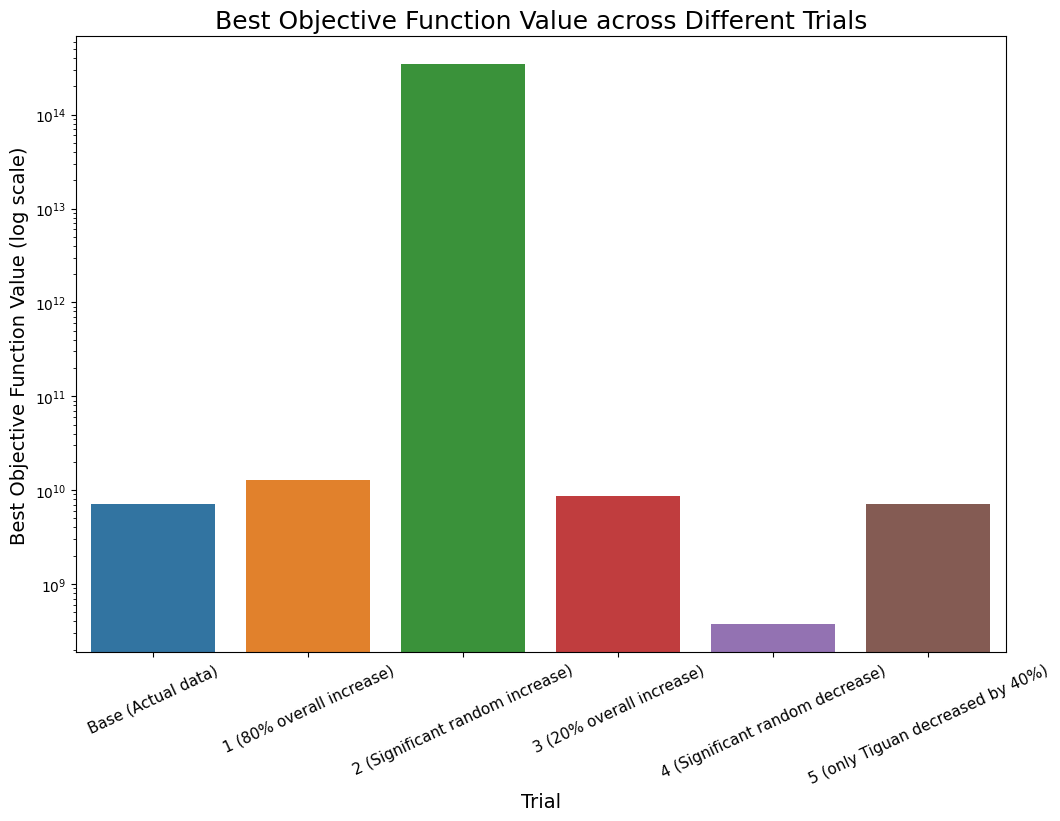

In [347]:
# Create a bar chart for 'Best Objective Function Value' across different trials using a logarithmic y-axis
plt.figure(figsize=(12, 8))
sns.barplot(x='Trial', y='Best Objective Function Value', data=df)
plt.yscale('log')  # Set logarithmic y-axis
plt.title('Best Objective Function Value across Different Trials', fontsize=18)
plt.xlabel('Trial', fontsize=14)
plt.ylabel('Best Objective Function Value (log scale)', fontsize=14)
# Set x-axis tick labels to include both 'Trial' and 'Trial Description'
x_tick_labels = [f"{trial} ({desc})" for trial, desc in zip(df['Trial'], df['Trial Description'])]
plt.xticks(range(len(df)), x_tick_labels, rotation=25, fontsize=11)
plt.show()